# Time Series on Taxi Data

This project focuses on developing a predictive model for Sweet Lift Taxi company to forecast hourly taxi demand at airports during peak hours. Using historical taxi order data, I will implement and compare multiple machine learning approaches including Linear Regression, Random Forest, LightGBM, and Moving Average models to predict the number of taxi orders for the next hour. With this, the goal is to achieve a Root Mean Square Error (RMSE) of 48 or lower on the test set, ensuring the model provides reliable predictions for operational decision-making. This time series forecasting will allow future analysts to solve a real-world business problem in the transportation industry.

## Initialization and Preparation

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
print(taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


In [4]:
taxi.isna().sum()

num_orders    0
dtype: int64

## Decomposition Data Analysis

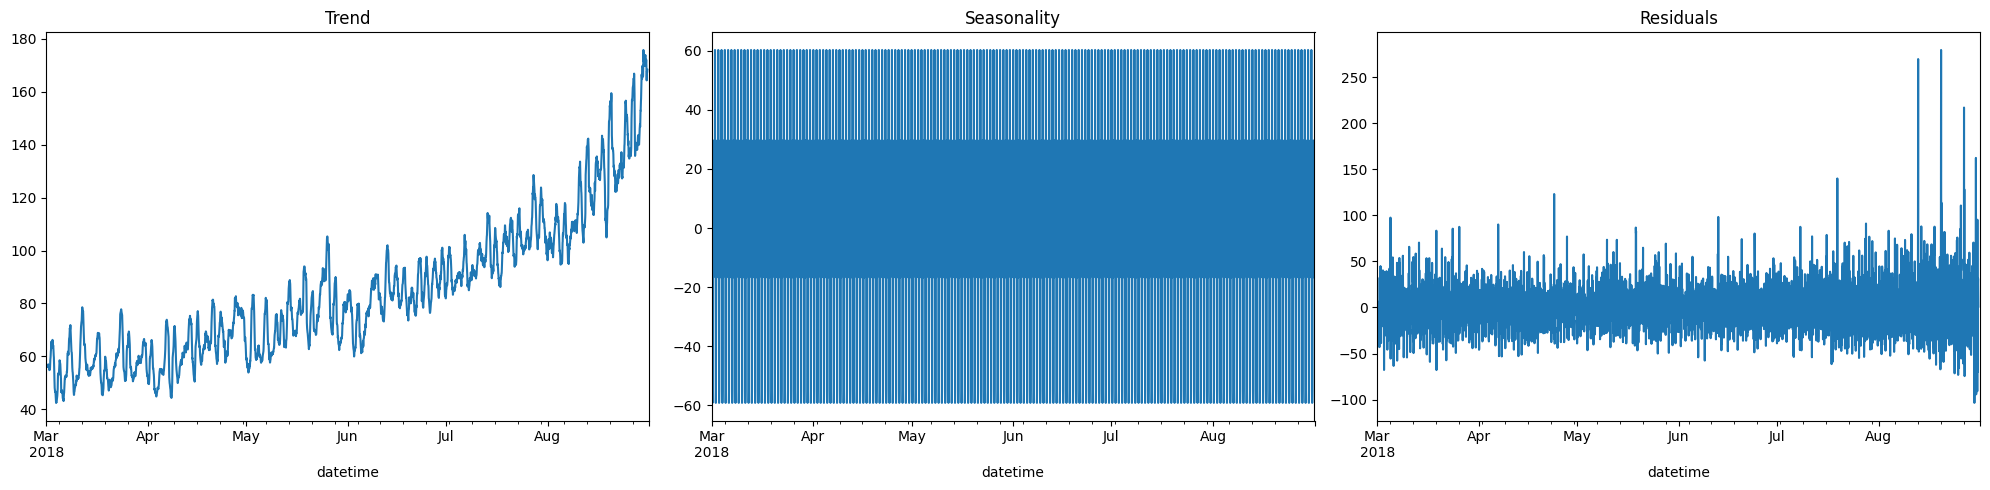

In [6]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
decomposed = seasonal_decompose(taxi['num_orders'])

plt.subplot(1, 3, 1, label='first_plot')
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(1, 3, 2, label='second_plot')
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(1, 3, 3, label='third_plot')
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

The decomposition analysis of the taxi order data shows three distinct components for forecasting model selection. The trend component shows a clear upward trend from March to August 2018, with taxi demand steadily increasing from 40-50 orders to 160-180 orders, showing strong business growth over time. The seasonality graph displays consistent cyclical patterns, suggesting predictable daily and weekly demand cycles. The residuals component has relatively stable variance around zero with occasional spikes, indicating that while the trend and seasonal patterns capture most of the variation, there are still factors that create unpredictable fluctuations in demand.

## Finding the Best Model

In [8]:
def features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

features(taxi, 11, 8)

In [9]:
def rmse(target_train, target_test):
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print(f'RSME for the training set: {math.sqrt(mean_squared_error(target_train, pred_train)):.2f}')
    print(f'RSME for the test set: {math.sqrt(mean_squared_error(target_test, pred_test)):.2f}')

In [10]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [11]:
model = LinearRegression()
model.fit(features_train, target_train)
print('Linear Regression Model')
rmse(target_train, target_test)

Linear Regression Model
RSME for the training set: 28.60
RSME for the test set: 47.24


In [12]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 100, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=54321)
        model.fit(features_train, target_train)
        predictions = model.predict(features_test)
        result = math.sqrt(mean_squared_error(target_test, predictions))
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

model = RandomForestRegressor(random_state=54321, max_depth=best_depth, n_estimators=best_est)
model.fit(features_train, target_train)
print(f'Random Forest Model')
rmse(target_train, target_test)

Random Forest Model
RSME for the training set: 13.77
RSME for the test set: 44.66


In [13]:
model = LGBMRegressor(n_estimators=150, random_state=12345)
model.fit(features_train, target_train)
print(f'LightGBM Model')
rmse(target_train, target_test)

LightGBM Model
RSME for the training set: 10.22
RSME for the test set: 44.92


In [14]:
res = arma_order_select_ic(y=target_train, max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]
model = ARIMA(target_train, order=(0, 0, ma_order))
model = model.fit()

train_pred = model.predict(start=0, end=len(target_train)-1)
train_rmse = math.sqrt(mean_squared_error(target_train, train_pred))

start_value = len(target_train)
end_value = len(target_train) + len(target_test) - 1
test_pred = model.predict(start=start_value, end=end_value, dynamic=False)
test_rmse = math.sqrt(mean_squared_error(target_test, test_pred))

print('Moving Average Model')
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Moving Average Model
Training RMSE: 29.56
Test RMSE: 74.35


## Conclusion

After analyzing Sweet Lift Taxi's historical order data, I tested several different forecasting models to predict taxi demand for the next hour, using Linear Regression, Random Forest, and LightGBM models to determine which one has the lowerst RMSE. The results showed that Random Forest achieved the best performance at a 44.66 testing RMSE, meaning it was the most accurate at predicting taxi demand and the best at meeting the company's requirement of keeping prediction errors below 48 orders per hour.